In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [4]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [5]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

{'below', 'from', 'after', 'did', 'very', 'now', 'ours', 'not', 'i', 'myself', 'what', 'wouldn', 'aren', 'to', "hasn't", 'these', 'am', 's', 'but', 'who', 'against', 'there', 'hadn', 'don', 'off', 'yourself', "shouldn't", 'those', 'wasn', 'were', 'needn', 'have', 't', 'ma', "aren't", "needn't", 'during', 'he', 'hers', 'ain', 'should', 'is', 'my', 'over', 'its', 'won', 'when', 'this', 'can', 'had', 'will', "don't", 'on', "couldn't", 'they', "weren't", 'in', 'himself', 'weren', 'both', 'd', 'their', 'shan', "mustn't", 'your', "wasn't", "mightn't", "wouldn't", 'itself', 'by', "hadn't", 've', "you'll", 'between', 'being', 'm', 'further', 'into', "won't", 'some', 'then', 'each', 'most', 'while', 'been', 'do', 'before', 'other', 'all', 'no', 'doing', 'an', 'me', 'if', 'more', "shan't", 'out', 'our', 'yours', 'her', 'his', 'for', 'or', "you're", 'are', 'about', "should've", 'didn', "you've", 'isn', 'at', 'that', 'here', 'through', 'yourselves', 'how', 'of', 'him', 'haven', "doesn't", 'above',

In [6]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows=5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


In [7]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
featur = []
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

featur= featur+vec.get_feature_names()

After vectorizations
(4000, 2782)
(1000, 2782)
(4000,)
(1000,)
...............................


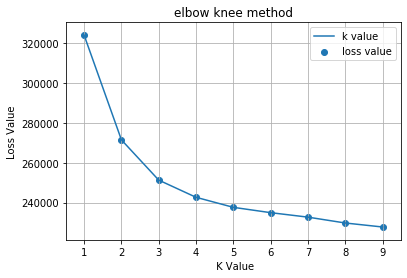

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
k=[]
iner=[]
for i in range(1,10):
    kmeans = KMeans(n_clusters=i).fit(train_cleanedtext)
    iner.append(kmeans.inertia_)
    k.append(i)
plt.plot(k,iner, label='k value')

plt.scatter(k,iner, label='loss value')


plt.legend()
plt.xlabel(" K Value")
plt.ylabel("Loss Value")
plt.title("elbow knee method")
plt.grid()
plt.show()

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


noofclusters = [2, 3,4,5,6,7,8]

for clusters in noofclusters:
    
    clust = KMeans(n_clusters=clusters)
    cluster_labels = clust.fit_predict(train_cleanedtext)

    
    silhouette_avg = silhouette_score(train_cleanedtext, cluster_labels)
    print("noofclusters =", clusters,
          "The average silhouette_score is :", silhouette_avg)


noofclusters = 2 The average silhouette_score is : 0.6297901120910802
noofclusters = 3 The average silhouette_score is : 0.46905182021931646
noofclusters = 4 The average silhouette_score is : 0.35273438727922135
noofclusters = 5 The average silhouette_score is : 0.22149112717615374
noofclusters = 6 The average silhouette_score is : 0.2668535970822252
noofclusters = 7 The average silhouette_score is : 0.2630629768264588
noofclusters = 8 The average silhouette_score is : 0.2717859690196625


In [11]:
kmeans = KMeans(n_clusters=2).fit(train_cleanedtext)
x=kmeans.labels_
print(x)

[1 1 1 ... 1 1 1]


In [12]:
print(kmeans.predict(test_cleanedtext))

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 